### This notebook analyze the data for all the sensers and I look at the frequency of failure for individual sensors and try to find the edge cases. Analyzing the edge case, I aim to see what could be the potential reason failure of sensors.

FYI: 

The sensor data is extracted for past 30 days.  
We are only considering a sensor failed if we do not have data for more than 1 hour in the database 

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

%matplotlib inline

In [94]:
import os

folder_path = 'data/'  # Replace with the actual folder path

# Get a list of all files in the folder
files = os.listdir(folder_path)

sensors = []
i = 0

dataframes = {}


for file in files:
    if file == '.DS_Store':
        pass
    else:
        name = file.replace('.csv', '')
        sensors.append(name)

        # adding data from csv file to the list of data which is placed in dataframe which is a list
        dataframes[name] = pd.read_csv('data/' + file)


In [95]:
print(f" We have data for {len(sensors)} sensors.")

 We have data for 52 sensors.


In [98]:
failing_detail = {} 
missing = {}
    
for i in range(len(sensors)):
    df = dataframes[sensors[i]]
    # Convert the 'time' column to datetime format (if it's not already)
    df['time'] = pd.to_datetime(df['time'])

    # Sort the DataFrame by the 'time' column
    df.sort_values('time', inplace=True)

    # Calculate the time difference between consecutive rows
    time_diff = df['time'].diff()

    # Find the indexes where the time difference is greater than one hour (3600 seconds)
    missing_indexes = time_diff[time_diff > pd.Timedelta(hours=1)].index

    missing[sensors[i]] = missing_indexes

    num = len(missing_indexes)
    
    # maintaining recored of failure for analysis
    failing_detail[sensors[i]] = num   
   

<AxesSubplot:>

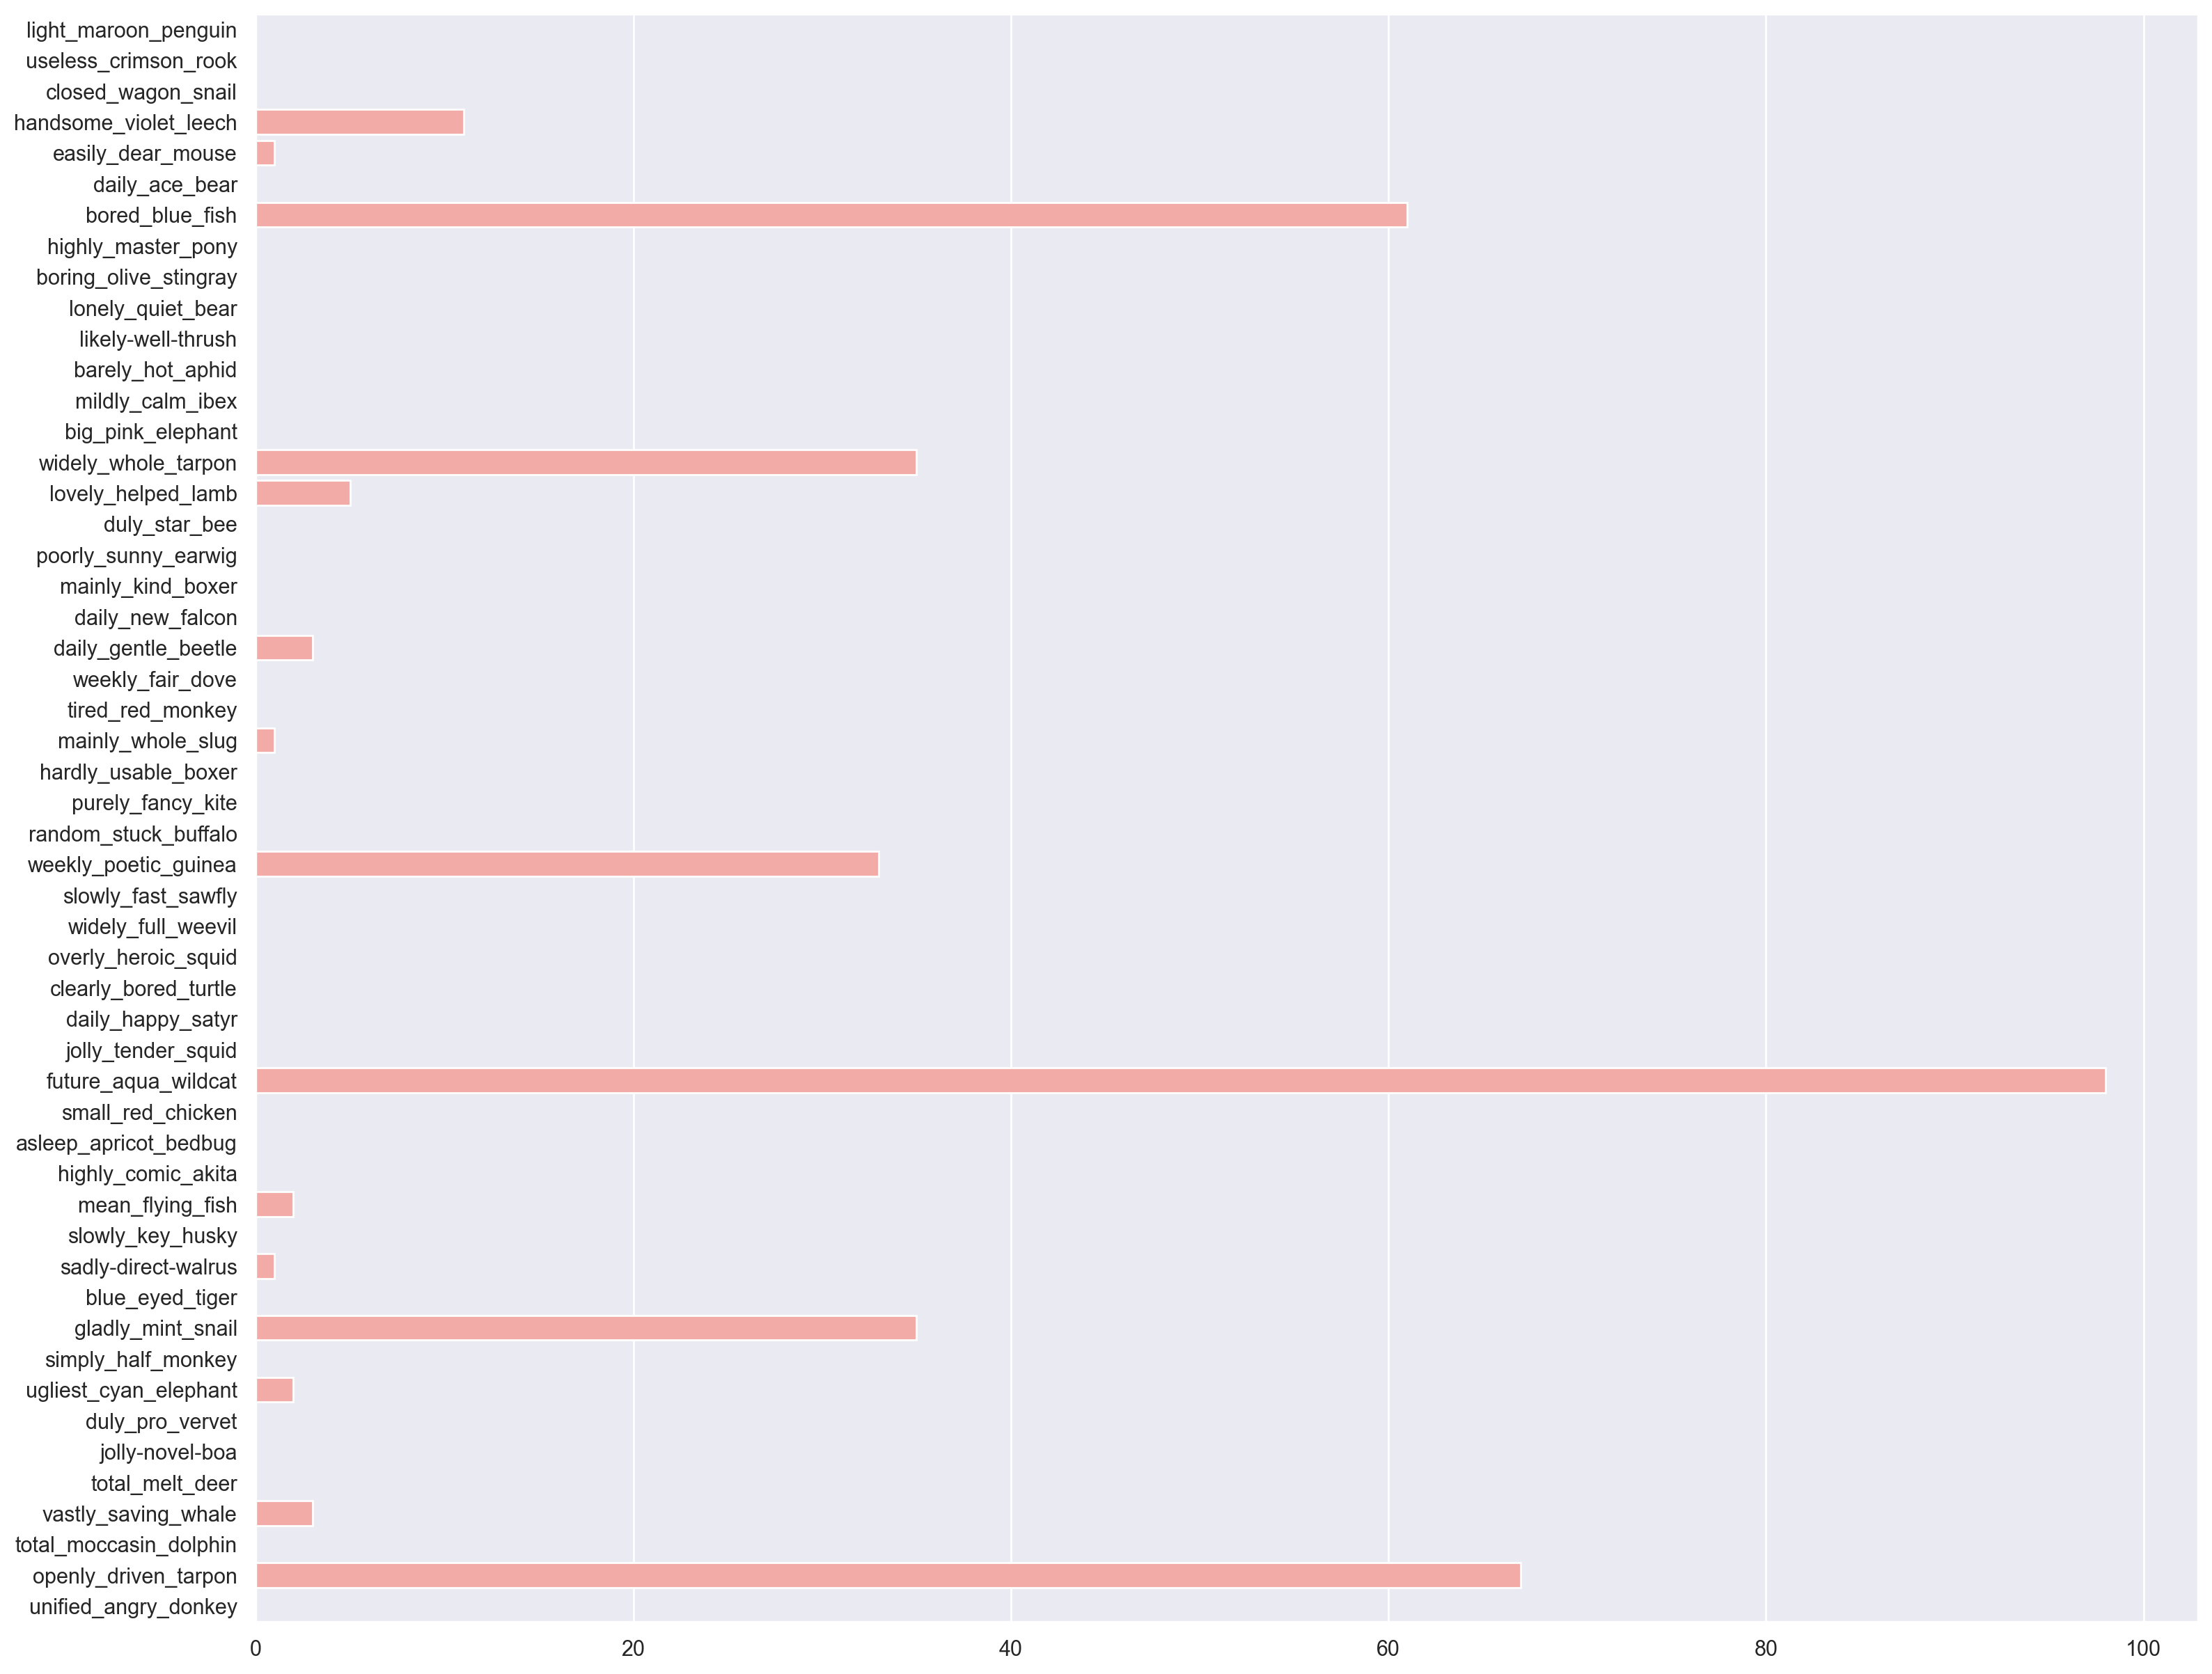

In [99]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(18,15)})
%config InlineBackend.figure_format = 'retina'

# plotting bar graph to see the frequency of failure for individual sensors

labels = list(failing_detail.keys())
heights = list(failing_detail.values())

sns.set_color_codes("pastel")
sns.barplot(x=heights, y=labels,
            label="Total", color="r", orient = 'h')

<AxesSubplot:ylabel='Count'>

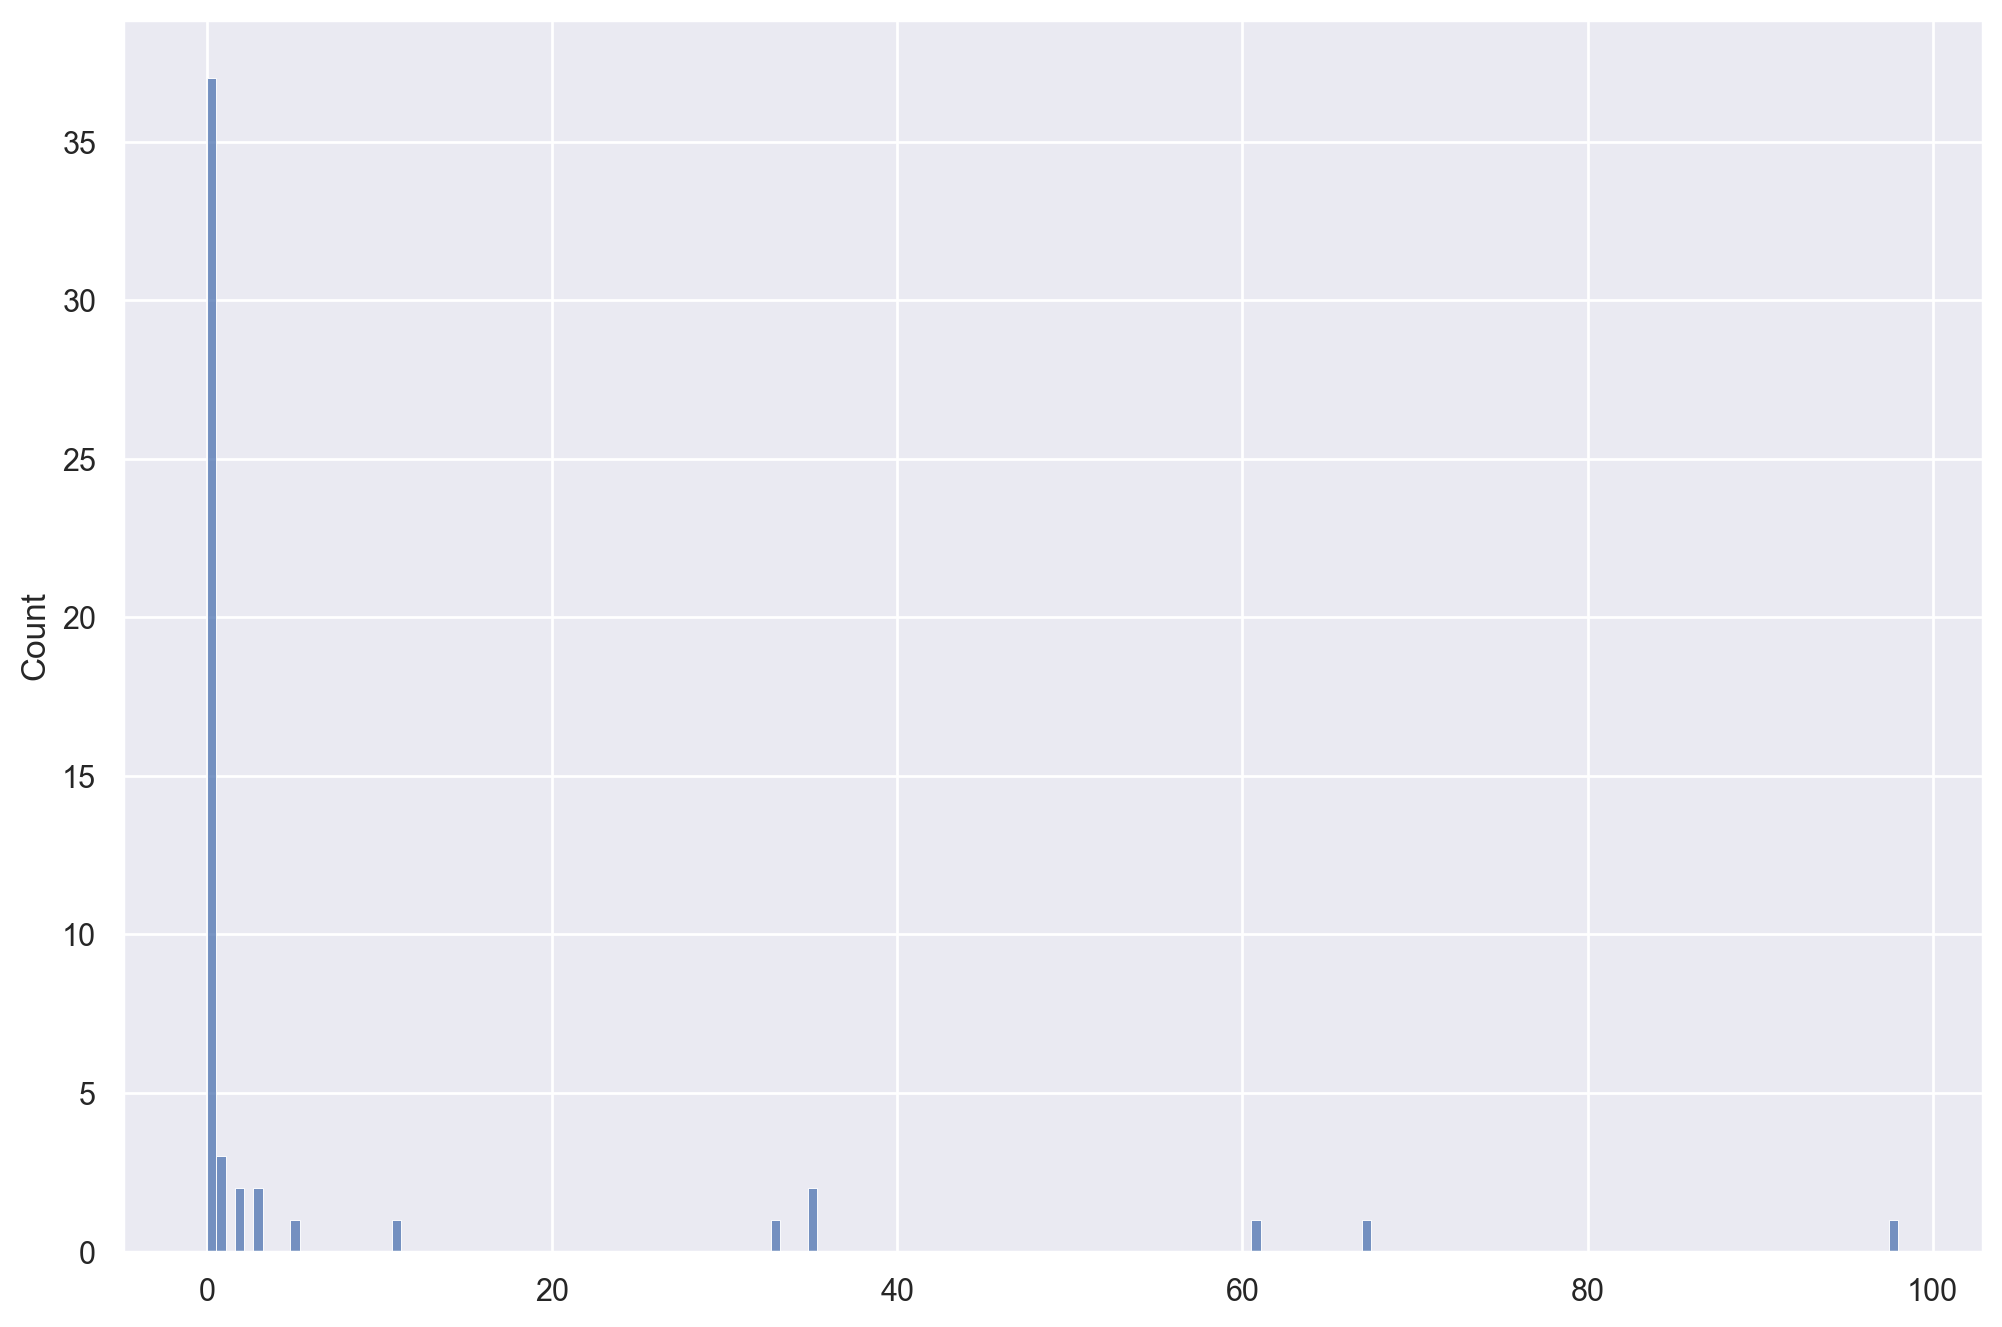

In [100]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.histplot(heights)

It seems that most of the sensor failed only a few times but there are quite a few sensors that failed for 20+. times in last 30 days. It would be interesting to see their data and see what could be reason for that failure.

In [101]:
# getting the list of sensors that has failed more more than x times and the indexes associated with that failure

interested_frequency = 20
mostly_failing_data = {}

for key, value in failing_detail.items():
    if value >=interested_frequency:
        mostly_failing_data[key] = missing[key]
        

In [102]:
len(mostly_failing_data)

6

### Analyzing data for battery voltage

So, I am trying to grab 2 data points before and after the failure of the sensor and see if there is any alarming value in battery voltage. 

In [103]:
## checking out battery voltage before and after the failure

# sns.set(rc = {'figure.figsize':(18,15)})
# figure, axis = plt.subplots(3, 4)


mostly_failing_data

{'bored_blue_fish': Int64Index([   2,   15,   16,   18,   20,   21,   27,   32,   49,   50,   53,
               55,   57,   58,   60,   62,   63,   71,   80,   89,   92,   93,
               96,   98,  106,  113,  128,  131,  133,  141,  144,  145,  146,
              149,  155,  158,  168,  181,  194,  200,  201,  207,  224,  229,
              239,  244,  250,  317,  324,  330,  335,  336,  339,  411,  443,
              455,  456,  462, 2333, 2341, 2692],
            dtype='int64'),
 'widely_whole_tarpon': Int64Index([1166, 1167, 1230, 1255, 1257, 1281, 1285, 1330, 1449, 1472, 1656,
             1672, 1733, 1803, 1911, 1979, 1982, 2020, 2035, 2145, 2149, 2239,
             2301, 2331, 2357, 2364, 2379, 2408, 2417, 2460, 2467, 2491, 2693,
             2696, 2723],
            dtype='int64'),
 'weekly_poetic_guinea': Int64Index([ 632,  639,  648,  654,  658,  662,  670,  710,  724,  730,  949,
             1023, 1032, 1075, 1083, 1087, 1119, 1186, 1194, 1225, 1226, 1244,
            

In [105]:
index = list(mostly_failing_data['humbly_modest_vervet'])
print(f" The length of interesting index is {len(index)}")

interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
interested_index

KeyError: 'humbly_modest_vervet'

In [ ]:
sns.set(rc = {'figure.figsize':(18,15)})
figure, axis = plt.subplots(2,3)
i = 1

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index]
    plt.subplot(3,2, i)
    plt.scatter(x = failing_df['times'], y = failing_df['batt_v'], c=np.random.rand(3,))
    plt.axhline(y=3.7, color = 'g')
    i += 1
    



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

In [80]:
x = dataframes['humbly_modest_vervet'].loc[range(1160, 1170)]
x

,Unnamed: 0,time,deployment_id,error_flag,batt_v,gw_1_id,dist_mm,f_cnt,gw_1_rssi_dbm,gw_1_snr_db,times,date
1160,1160,2023-06-08 12:46:23.380000+00:00,widely_whole_tarpon,0.0,4.142,floodnet-ltap-gw-553232201d003500,2752.0,22369,-109,-6.00,12:46:23.380000,2023-06-08
1161,1161,2023-06-08 12:48:29.723000+00:00,widely_whole_tarpon,0.0,4.142,floodnet-ltap-gw-553232201d003500,2750.0,22371,-102,-5.00,12:48:29.723000,2023-06-08
1162,1162,2023-06-08 13:05:19.581000+00:00,widely_whole_tarpon,0.0,4.140,floodnet-ltap-gw-553232201d003500,2754.0,22387,-105,-5.00,13:05:19.581000,2023-06-08
1163,1163,2023-06-08 13:08:29.112000+00:00,widely_whole_tarpon,0.0,4.140,floodnet-ltap-gw-553232201d003500,2746.0,22390,-97,-5.00,13:08:29.112000,2023-06-08
1164,1164,2023-06-08 13:45:21.629000+00:00,widely_whole_tarpon,0.0,4.136,floodnet-ltap-gw-553232201d003500,2752.0,22425,-105,-8.25,13:45:21.629000,2023-06-08
1165,1165,2023-06-08 14:05:22.774000+00:00,widely_whole_tarpon,0.0,4.136,floodnet-ltap-gw-553232201d003500,2755.0,22444,-96,-7.50,14:05:22.774000,2023-06-08
1166,1166,2023-06-08 15:17:58.805000+00:00,widely_whole_tarpon,0.0,4.130,floodnet-ltap-gw-553232201d003500,2762.0,22513,-105,-5.50,15:17:58.805000,2023-06-08
1167,1167,2023-06-08 17:14:53.177000+00:00,widely_whole_tarpon,0.0,4.124,floodnet-ltap-gw-553232201d003500,2746.0,22624,-104,-5.25,17:14:53.177000,2023-06-08
1168,1168,2023-06-08 17:25:23.583000+00:00,widely_whole_tarpon,0.0,4.122,floodnet-ltap-gw-553232201d003500,2755.0,22634,-107,-4.25,17:25:23.583000,2023-06-08
1169,1169,2023-06-08 17:29:36.932000+00:00,widely_whole_tarpon,0.0,4.124,floodnet-ltap-gw-553232201d003500,2752.0,22638,-102,-6.75,17:29:36.932000,2023-06-08
